DataGenerator.py  demo_params.fbs	  generators  struct_0.fbs
converters	  example_pipeline.ipynb  res
/home/aroot/stuff/data-analysis/src/data-tools/demo


In [2]:

!./converters/StructureGenerator.py -f ./res/posStruc.npy

!./converters/ParameterGenerator.py -a [0.1] \
 -d [0.5,4,10] \
 -bf [1.0] \
 -id [7.0,8.0,9] \
 -np [128] \
 -pw [0.3] \
 -s [1.0] \
 -ew [0.019866] \
 -snr [1.0] \
 -ep [25.0,26.0,27] \
 -seed [28.0,29.0,30] \
 -st [31.0,32.0,33] \
 -c [34.0,35.0,36] \
 -o demo_params.fbs
 
!./DataGenerator.py images -p demo_params.fbs -s struct_0.fbs
!./DataGenerator.py ctfs -p demo_params.fbs

(10, 10, 3)
[0.1]
[0.5, 4.0, 10.0]
[1.0]
[7.0, 8.0, 9.0]
[128.0]
[0.3]
[1.0]
[0.019866]
[1.0]
[25.0, 26.0, 27.0]
[28.0, 29.0, 30.0]
[31.0, 32.0, 33.0]
[34.0, 35.0, 36.0]
demo_params.fbs
10
Generating images for batch:   0%|                        | 0/1 [00:00<?, ?it/s]tensor([[[ 5.3060, -3.9180, -5.0120],
         [ 3.5360, -3.5380, -1.6420],
         [ 4.3460, -1.3880,  1.4480],
         [ 3.4160,  2.0920,  0.0480],
         [ 0.7460,  3.2220,  2.5880],
         [-0.7040,  5.4320, -0.3120],
         [-0.8840,  2.1420, -2.3120],
         [-3.9540,  1.3820, -0.1220],
         [-4.4440, -1.9380,  1.6780],
         [-7.3640, -3.4880,  3.6380]]], dtype=torch.float64)
Generating images for batch: 100%|███████████████| 1/1 [00:00<00:00, 108.23it/s]
ctfs_wrapper
torch.Size([10, 128, 128])


In [6]:
from res.inspector import *
# def serialize_fbs_dataset(filename):
#     data_numpy = []
#     data_list = DataSetT.InitFromObj(
#         DataSet.GetRootAsDataSet(dl.load_flatbuffer(filename), 0)
#     )
#     for i in data_list.data:
#         m1 = i.m1
#         r = np.array(m1.realPixels, dtype=complex).reshape((128, 128))
#         im = np.array(m1.imagPixels, dtype=complex).reshape((128, 128))
#         data_numpy.append(r + (1j * im))

#     np.save(f"serialized_{filename.split('.')[0]}.npy", np.array(data_numpy, dtype=complex))


In [10]:
from res.inspector import *
serialize_fbs_dataset("ctfs.fbs")
serialize_fbs_dataset("images.fbs")

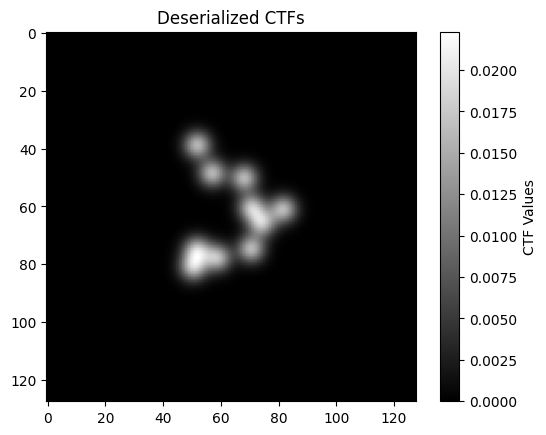

In [13]:
import matplotlib.pyplot as plt
serialized_imgs = np.load("serialized_images.npy")
plt.imshow(np.real(serialized_imgs[0]),cmap='gray')
plt.title("Deserialized CTFs")
plt.colorbar(label="CTF Values")
plt.show()


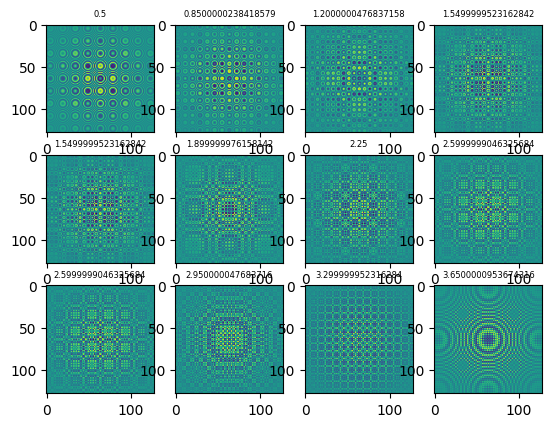

In [20]:

ctf_paramSet_buf = ParametersT.InitFromObj(DataSet.GetRootAsDataSet(dl.load_flatbuffer("ctfs.fbs"),0).Params())
serialized_ctfs = np.load("serialized_ctfs.npy")

row = 3
col = 4
f = 0
fig,axes = plt.subplots(row,col)
for i in range(row):
    for j in range(col):
        # print())
        axes[i,j].imshow(np.real(np.fft.fftshift(serialized_ctfs[(i+f)*row + j])))
        # axes[i,j].imshow(get_phase(np.fft.fftshift(b[(i+f)*row+j]),128),cmap="Greys")
        axes[i,j].set_title(f"{ctf_paramSet_buf.defocus[(i+f)*row+j]}",fontsize=6)

